# Nettverksanalyse i sgis
https://github.com/statisticsnorway/ssb-sgis

Notebook-en kan kjøres i dapla hvis man har tilgang til bøtta 'kart'.

Eller åpnes her: https://nbviewer.org/github/statisticsnorway/intro_til_geopandas/blob/main/3_nettverksanalyse_lang.ipynb

Innhold:
- Klargjøre vegdata for nettverksanalyse
- get_route_frequency: Tell opp antall ganger hver veg blir brukt
- service_area: Finn området som kan nås innen gitte reisetider
- od_cost_matrix: Rask beregning av reisetid fra start- til sluttpunkter
- get_route: Finn raskeste rute(r) fra A til B

In [1]:
# for å installere, kjør i terminalen:
# poetry add ssb-sgis

In [2]:
import numpy as np
import sgis as sg

## Hente vegdata

Henter vegdata i Oslo for 2022.

Dataene kan leses direkte herfra:

In [3]:
url = "https://media.githubusercontent.com/media/statisticsnorway/ssb-sgis/main/tests/testdata/roads_oslo_2022.parquet"
veger = sg.read_parquet_url(url)
veger

linkid fromnode   tonode         streetname fromangle toangle  \
119702    121690   135529   135537       skogsbilsveg       203     187   
199710    203624   223290   223291              Rv163       107     107   
199725    203640   223291   223306              Rv163       107     107   
199726    203641   223291   223307              Rv163        85      85   
199733    203648   223313   223291              Rv163       135     135   
...          ...      ...      ...                ...       ...     ...   
1944129  2137454  1836098  1836031              Rv191        74      74   
1944392  2137723   575129  1836232     Bygdøynesveien       333     333   
1944398  2137729  1836234  1836235  Fredriksborgveien       183     183   
1944409  2137741  1836240  1481147  Fredriksborgveien       178     178   
1944415  2137747  1493921  1836244         privat veg       234     329   

        formofway funcroadclass  routeid  from_measure  ...  \
119702          1             7  1058193      0.972103  ...   
199710          2             2  1209419      0.000000  ...   
199725          2             2  1209420      0.000000  ...   
199726          2             2  1209421      0.000000  ...   
199733          2             2  1209423      0.000000  ...   
...           ...           ...      ...           ...  ...   
1944129         5             2  1830201      0.919438  ...   
1944392         1             7  3165154      0.000000  ...   
1944398         1             7  3165155      0.000000  ...   
1944409         1             7  3165155      0.750896  ...   
1944415         1             7  3165156      0.000000  ...   

         estimateddrivetimetruck_bw drivetimetourist_fw drivetimetourist_bw  \
119702                     0.188357            0.216611            0.216611   
199710                    -1.000000            0.099323           -1.000000   
199725                    -1.000000            0.173963           -1.000000   
199726                    -1.000000            0.011827           -1.000000   
199733                    -1.000000            0.009097           -1.000000   
...                             ...                 ...                 ...   
1944129                   -1.000000            0.010482           -1.000000   
1944392                    0.117879            0.135561            0.135561   
1944398                    0.059338            0.068239            0.068239   
1944409                    0.020547            0.023629            0.023629   
1944415                    0.717860            0.175876            0.175876   

        drivetimebus_fw drivetimebus_bw estimateddrivetimebus_fw  \
119702         0.216611        0.216611                 0.188357   
199710         0.099323       -1.000000                 0.086368   
199725         0.173963       -1.000000                 0.151272   
199726         0.011827       -1.000000                 0.010284   
199733         0.009097       -1.000000                 0.007910   
...                 ...             ...                      ...   
1944129        0.010482       -1.000000                 0.027344   
1944392        0.135561        0.135561                 0.117879   
1944398        0.068239        0.068239                 0.059338   
1944409        0.023629        0.023629                 0.020547   
1944415        0.175876        0.175876                 0.717860   

        estimateddrivetimebus_bw  lengde SHAPE_Length  \
119702                  0.188357     NaN    36.838554   
199710                 -1.000000     NaN   110.359439   
199725                 -1.000000     NaN   193.291970   
199726                 -1.000000     NaN    13.141298   
199733                 -1.000000     NaN    10.107394   
...                          ...     ...          ...   
1944129                -1.000000     NaN     8.735034   
1944392                 0.117879     NaN    46.109289   
1944398                 0.059338     NaN    23.210556   
1944409         

Eller herfra, hvis man har tilgang til kart-bøtta:

In [4]:
kartdata = "ssb-prod-kart-data-delt/kartdata_analyse/klargjorte-data"

veger = (
    sg.read_geopandas(
        f"{kartdata}/2022/NVDB_ruteplan_nettverk_p20220703_v1.parquet",
        filters=[("KOMMUNENR", "in",  ("0301", "3024", "3020"))],
        columns=["oneway", "drivetime_fw", "drivetime_bw", "geometry"]
    )
    .sort_values("oneway")
    .reset_index(drop=True)
)

veger

oneway  drivetime_fw  drivetime_bw  \
0           B      0.216611      0.216611   
1           B      0.062602      0.062602   
2           B      0.053945      0.053945   
3           B      0.135625      0.135625   
4           B      0.111156      0.111156   
...       ...           ...           ...   
119295     TF     -1.000000      0.101898   
119296     TF     -1.000000      0.019263   
119297     TF     -1.000000      0.005270   
119298     TF     -1.000000      0.028626   
119299     TF     -1.000000      0.092640   

                                                 geometry  
0       MULTILINESTRING Z ((258028.440 6674249.890 413...  
1       MULTILINESTRING Z ((265347.560 6654750.570 230...  
2       MULTILINESTRING Z ((268027.000 6646538.600 160...  
3       MULTILINESTRING Z ((262066.673 6655401.898 212...  
4       MULTILINESTRING Z ((268124.331 6646443.504 160...  
...                                                   ...  
119295  MULTILINESTRING Z ((263061.100 6651519.800 55....  
119296  MULTILINESTRING Z ((247488.922 6649695.927 26....  
119297  MULTILINESTRING Z ((247490.918 6649692.213 26....  
119298  MULTILINESTRING Z ((248167.570 6649285.687 31....  
119299  MULTILINESTRING Z ((265986.345 6627160.435 125...  

[119300 rows x 4 columns]

Velger kun relevante kolonner for dette formålet: retning og kjøretid.

## Gjør klar til nettverksanalyse

Starter med å definere noen regler for analysene.

Her vil jeg beregne kjøretid med bil. Setter derfor vekt-kolonnen til "minutes" og directed til True (som betyr at man bare kan bevege seg i én retning langs vegene).

In [5]:
regler = sg.NetworkAnalysisRules(
    weight="minutes",
    directed=True,
    search_tolerance=500, # meter
)
regler

NetworkAnalysisRules(directed=True, weight='minutes', search_tolerance=500, search_factor=0, split_lines=True, nodedist_multiplier=None, nodedist_kmh=None)

For å få et vegnett der alle veger går i riktig retning, må man snu vegene som går i motsatt/begge retning(er).

In [6]:
antall_per_retning = veger.oneway.value_counts().to_frame()

antall_per_retning["hva_må_gjøres"] = {"B": "Duplisere og snu duplikatene", "TF": "Snu", "FT": "Ingenting"}

antall_per_retning

count                 hva_må_gjøres
oneway                                      
B       102631  Duplisere og snu duplikatene
FT       10924                     Ingenting
TF        5745                           Snu

Og man må lage en felles minutt-kolonne av kjøretid-kolonnene.

In [7]:
veger[["oneway", "drivetime_fw", "drivetime_bw"]]

oneway  drivetime_fw  drivetime_bw
0           B      0.216611      0.216611
1           B      0.062602      0.062602
2           B      0.053945      0.053945
3           B      0.135625      0.135625
4           B      0.111156      0.111156
...       ...           ...           ...
119295     TF     -1.000000      0.101898
119296     TF     -1.000000      0.019263
119297     TF     -1.000000      0.005270
119298     TF     -1.000000      0.028626
119299     TF     -1.000000      0.092640

[119300 rows x 3 columns]

Dette kan gjøres sånn her:

In [8]:
veger_med_retning = sg.make_directed_network_norway(veger, dropnegative=True)
veger_med_retning

oneway   minutes                                           geometry
0           B  0.216611  MULTILINESTRING Z ((258028.440 6674249.890 413...
1           B  0.062602  MULTILINESTRING Z ((265347.560 6654750.570 230...
2           B  0.053945  MULTILINESTRING Z ((268027.000 6646538.600 160...
3           B  0.135625  MULTILINESTRING Z ((262066.673 6655401.898 212...
4           B  0.111156  MULTILINESTRING Z ((268124.331 6646443.504 160...
...       ...       ...                                                ...
221822     TF  0.101898  MULTILINESTRING Z ((263009.600 6651564.100 54....
221823     TF  0.019263  MULTILINESTRING Z ((247482.167 6649709.778 26....
221824     TF  0.005270  MULTILINESTRING Z ((247488.922 6649695.927 26....
221825     TF  0.028626  MULTILINESTRING Z ((248151.801 6649269.396 31....
221826     TF  0.092640  MULTILINESTRING Z ((265966.376 6627206.697 126...

[221827 rows x 3 columns]

In [9]:
print("Kilometer før:", veger.length.sum() / 1000)
print("Kilometer nå:", veger_med_retning.length.sum() / 1000)

Kilometer før: 5663.95873677671
Kilometer nå: 10705.69080730138


In [10]:
veger_med_retning.minutes

0         0.216611
1         0.062602
2         0.053945
3         0.135625
4         0.111156
            ...   
221822    0.101898
221823    0.019263
221824    0.005270
221825    0.028626
221826    0.092640
Name: minutes, Length: 221827, dtype: float64

Man bør også fjerne isolerte nettverksøyer. Dette er gjerne veger bak bommer (innkjørsler, inni borettslag).

Sånn her kan man finne og fjerne nettverksøyene:

In [11]:
veger_ned_tilknytning = sg.get_connected_components(veger_med_retning).query("connected == 1")
veger_ned_tilknytning

oneway   minutes                                           geometry  \
1           B  0.062602  LINESTRING Z (265347.560 6654750.570 230.981, ...   
2           B  0.053945  LINESTRING Z (268027.000 6646538.600 160.863, ...   
3           B  0.135625  LINESTRING Z (262066.673 6655401.898 212.598, ...   
4           B  0.111156  LINESTRING Z (268124.331 6646443.504 160.221, ...   
5           B  0.042334  LINESTRING Z (267727.700 6646980.000 181.563, ...   
...       ...       ...                                                ...   
221822     TF  0.101898  LINESTRING Z (263009.600 6651564.100 54.560, 2...   
221823     TF  0.019263  LINESTRING Z (247482.167 6649709.778 26.419, 2...   
221824     TF  0.005270  LINESTRING Z (247488.922 6649695.927 26.548, 2...   
221825     TF  0.028626  LINESTRING Z (248151.801 6649269.396 31.281, 2...   
221826     TF  0.092640  LINESTRING Z (265966.376 6627206.697 126.538, ...   

        connected  
1             1.0  
2             1.0  
3             1.0  
4             1.0  
5             1.0  
...           ...  
221822        1.0  
221823        1.0  
221824        1.0  
221825        1.0  
221826        1.0  

[204464 rows x 4 columns]

In [12]:
print("Kilometer før:", veger_med_retning.length.sum() / 1000)
print("Kilometer nå:", veger_ned_tilknytning.length.sum() / 1000)

Kilometer før: 10705.69080730138
Kilometer nå: 9522.320634061576


In [13]:
sg.samplemap(veger_med_retning, veger_ned_tilknytning)

center=(258390.86261584033, 6648229.964901017), size=1000


Nå er vegene klare for nettverksanalyse:

In [14]:
nwa = sg.NetworkAnalysis(network=veger_ned_tilknytning, rules=regler)
nwa

NetworkAnalysis(
    network=Network(9522 km, percent_bidirectional=85),
    rules=NetworkAnalysisRules(weight=minutes, directed=True, search_tolerance=500, search_factor=0, split_lines=True, ...),
    log=True, detailed_log=False,
)

### Først en liten test av retning
La oss teste at retningen lages riktig.

Sjekker at tur-retur Vippetangen-Ryen går i riktige tunnelløp.

In [15]:
vippetangen = sg.to_gdf([10.741527, 59.9040595], crs=4326).to_crs(veger.crs)
ryen = sg.to_gdf([10.8047522, 59.8949826], crs=4326).to_crs(veger.crs)

OBS: Å beregne én rute av gangen går mye treigere enn å beregne mange samtidig.

In [16]:
ryen_til_vippa = nwa.get_route(ryen, vippetangen)
vippa_til_ryen = nwa.get_route(vippetangen, ryen)
sg.explore(ryen_til_vippa, vippa_til_ryen)

Nå litt skikkelig analyse. Henter 1000 tilfeldige adresser i Oslo.

In [17]:
url = "https://media.githubusercontent.com/media/statisticsnorway/ssb-sgis/main/tests/testdata/points_oslo.parquet"
punkter = sg.read_parquet_url(url)[["geometry"]]
punkter

geometry
0    POINT (263122.700 6651184.900)
1    POINT (272456.100 6653369.500)
2    POINT (270082.300 6653032.700)
3    POINT (259804.800 6650339.700)
4    POINT (272876.200 6652889.100)
..                              ...
995  POINT (266801.700 6647844.500)
996  POINT (261274.000 6653593.400)
997  POINT (263542.900 6645427.000)
998  POINT (269226.700 6650628.000)
999  POINT (264570.300 6644239.500)

[1000 rows x 1 columns]

In [19]:
aar = 2024

bygningspunktsti = f"ssb-prod-areal-data-produkt/arealstat/inndata/{aar}/SMAT_bygg_punkt_p{aar}_v1.parquet"

bygg = sg.read_geopandas(
    bygningspunktsti,
    filters=[("KOMMUNENR", "in",  ("0301", "3024", "3020"))],
    columns=["geometry"]
)

punkter = bygg.sample(1000).reset_index(drop=True)
punkter

geometry
0    POINT (256886.000 6654285.000)
1    POINT (263736.000 6652841.000)
2    POINT (261839.000 6654820.000)
3    POINT (259664.000 6654888.000)
4    POINT (263315.000 6651596.000)
..                              ...
995  POINT (264576.000 6652762.000)
996  POINT (263364.000 6645643.000)
997  POINT (264890.000 6647070.000)
998  POINT (264578.000 6644013.000)
999  POINT (258035.000 6657027.000)

[1000 rows x 1 columns]

## Finn rutefrekvens
Finner antall ganger hver veg blir brukt fra 100 til 100 punkter, altså 10 000 reiser til sammen.

In [20]:
frequencies = nwa.get_route_frequencies(
    origins=punkter.sample(100),
    destinations=punkter.sample(100),
)

frequencies.nlargest(3, "frequency")

oneway   minutes  connected  idx_orig  \
203595     TF  0.009911        1.0    221335   
199788     TF  0.053144        1.0    217496   
203594     TF  0.006419        1.0    221334   

                                          source_wkt  \
203595   POINT (265567.1579999998 6650542.835999999)   
199788  POINT (265530.46999999974 6650587.640000001)   
203594   POINT (265563.1500000004 6650547.619999999)   

                                         target_wkt  source  target  n_source  \
203595          POINT (265573.4060000004 6650535.5)  101406   98326         2   
199788  POINT (265563.1500000004 6650547.619999999)   99530  101405         3   
203594  POINT (265567.1579999998 6650542.835999999)  101405  101406         2   

        n_target     meters  splitted  temp_idx__  frequency  \
203595         3   9.636099       NaN      203970     1431.0   
199788         2  51.668006       NaN      200161     1431.0   
203594         2   6.241051       NaN      203969     1431.0   

                                                 geometry  
203595  LINESTRING Z (265567.158 6650542.836 89.522, 2...  
199788  LINESTRING Z (265530.470 6650587.640 88.527, 2...  
203594  LINESTRING Z (265563.150 6650547.620 89.382, 2...

Kartlegg resultatene.

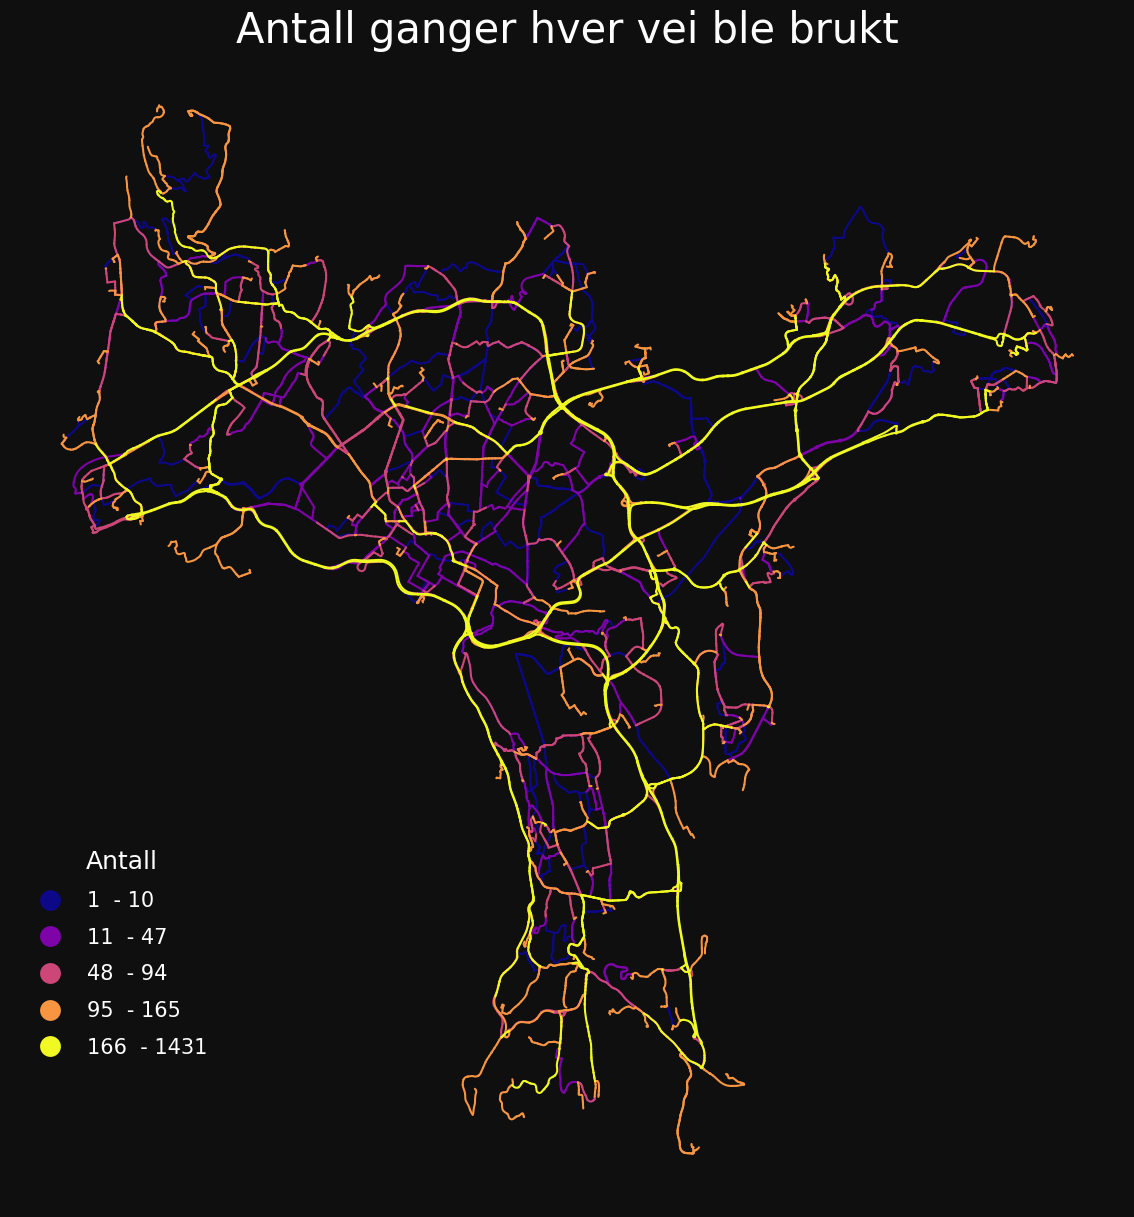

In [21]:
m = sg.ThematicMap(sg.buff(frequencies, 18), column="frequency", size=15)
m.black = True
m.cmap = "plasma" # fargepaletten
m.title = "Antall ganger hver vei ble brukt"
m.legend.title = "Antall"
m.plot()

### Service area

Finner veiene som kan nås innen 1 til 10 minutter fra et tilfeldig bygg. 

In [22]:
service_areas = nwa.service_area(
    punkter.sample(1),
    breaks=np.arange(1, 11),
)

service_areas

origin  minutes                                           geometry
0     255        1  MULTILINESTRING Z ((267644.500 6645074.900 174...
1     255        2  MULTILINESTRING Z ((267835.600 6645576.200 170...
2     255        3  MULTILINESTRING Z ((267523.941 6645586.762 159...
3     255        4  MULTILINESTRING Z ((267744.000 6646183.300 159...
4     255        5  MULTILINESTRING Z ((268027.000 6646538.600 160...
5     255        6  MULTILINESTRING Z ((267727.700 6646980.000 181...
6     255        7  MULTILINESTRING Z ((267730.734 6646997.114 181...
7     255        8  MULTILINESTRING Z ((265248.600 6647373.200 131...
8     255        9  MULTILINESTRING Z ((264861.984 6644572.167 126...
9     255       10  MULTILINESTRING Z ((264743.106 6644482.590 124...

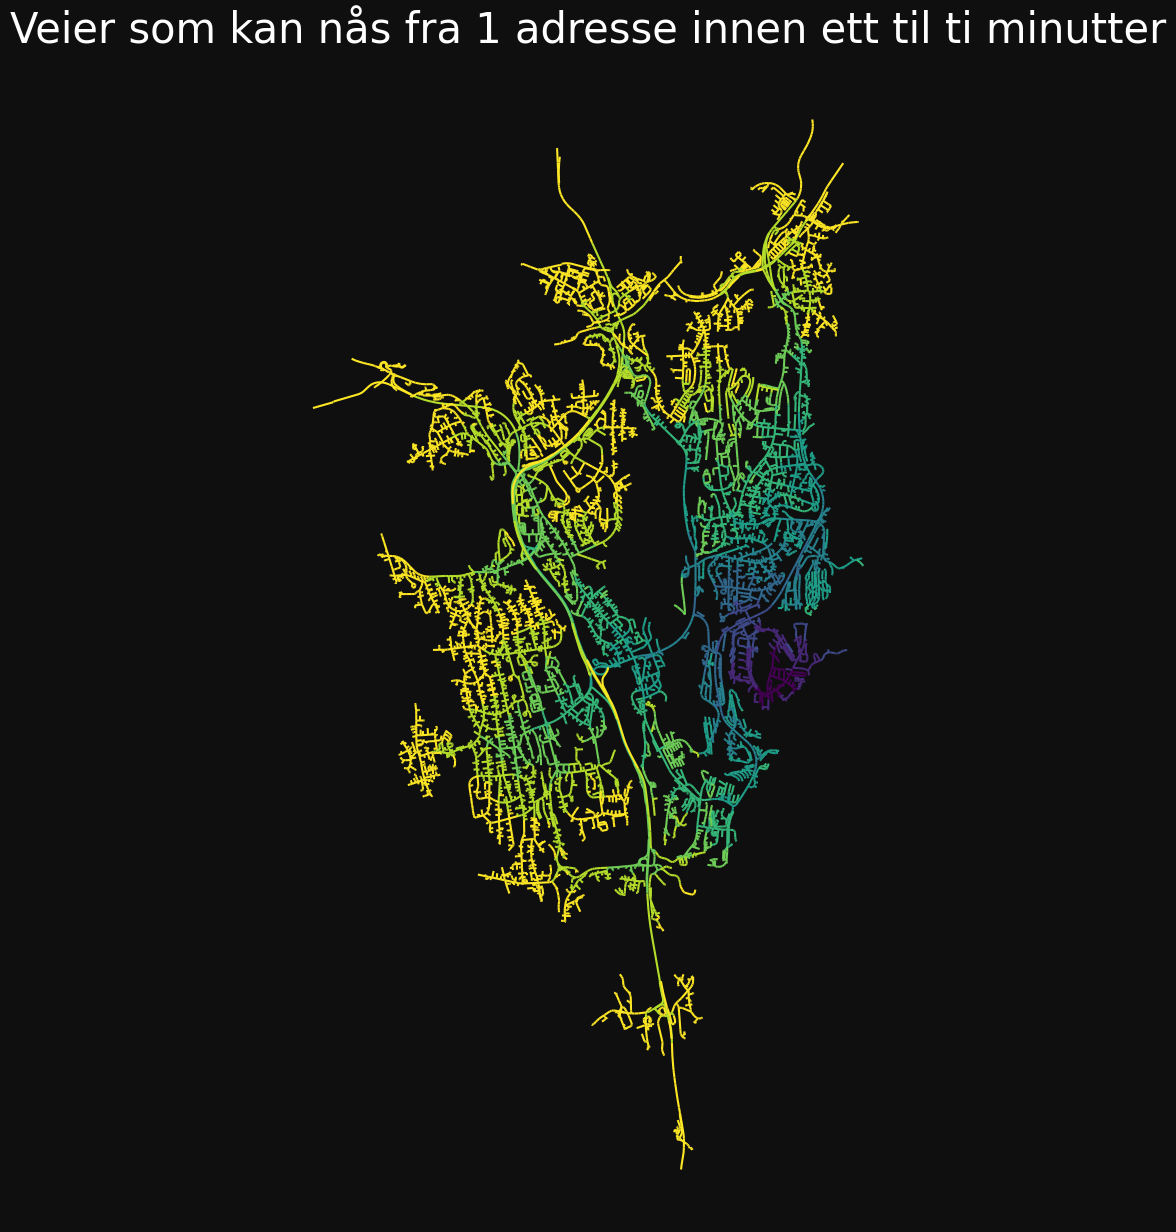

In [23]:
m = sg.ThematicMap(service_areas, column="minutes", size=15)
m.black = True
m.k = 10
m.title = "Veier som kan nås fra 1 adresse innen ett til ti minutter"
m.legend = False
m.plot()

Sjekke loggen:

In [24]:
nwa.log

endtime  minutes_elapsed                 method  origins_count  \
0 2024-03-11 14:57:20              0.5              get_route              1   
1 2024-03-11 14:57:57              0.6              get_route              1   
2 2024-03-11 15:01:26              1.7  get_route_frequencies            100   
3 2024-03-11 15:02:12              0.6           service_area              1   

  destinations_count  percent_missing  cost_mean  percent_bidirectional  
0                  1              0.0   5.748210                     85  
1                  1              0.0   4.818508                     85  
2                100              0.0   0.073650                     85  
3               <NA>              0.0   5.500000                     85

### Reisetider: OD Cost Matrix

In [25]:
od = nwa.od_cost_matrix(punkter, punkter)
od

origin  destination    minutes
0            0            0   0.000000
1            0            1  14.321483
2            0            2  12.366217
3            0            3  11.744793
4            0            4  14.095498
...        ...          ...        ...
999995     999          995  18.308947
999996     999          996  26.868765
999997     999          997  27.924596
999998     999          998  30.491705
999999     999          999   0.000000

[1000000 rows x 3 columns]

Sjekk hvor mange prosent som mangler:

In [26]:
od.minutes.isna().mean() * 100

2.8773

Kolonnene 'origin' og 'destination' bruker index-en til inputene.

Man kan derfor enkelt koble resultatene med start- og sluttpunktene, som her er samme datasett.

In [27]:
joinet = punkter.join(od.set_index("origin"))
joinet

geometry  destination    minutes
0    POINT (256886.000 6654285.000)            0   0.000000
0    POINT (256886.000 6654285.000)            1  14.321483
0    POINT (256886.000 6654285.000)            2  12.366217
0    POINT (256886.000 6654285.000)            3  11.744793
0    POINT (256886.000 6654285.000)            4  14.095498
..                              ...          ...        ...
999  POINT (258035.000 6657027.000)          995  18.308947
999  POINT (258035.000 6657027.000)          996  26.868765
999  POINT (258035.000 6657027.000)          997  27.924596
999  POINT (258035.000 6657027.000)          998  30.491705
999  POINT (258035.000 6657027.000)          999   0.000000

[1000000 rows x 3 columns]

Eller koble på aggregert data:

In [28]:
punkter["minutes_mean"] = od.groupby("origin").minutes.mean()
punkter["n_missing"] = len(punkter) - od.groupby("origin", dropna=False).minutes.count()
punkter

geometry  minutes_mean  n_missing
0    POINT (256886.000 6654285.000)     18.437277         15
1    POINT (263736.000 6652841.000)     12.224106         15
2    POINT (261839.000 6654820.000)     15.764892         15
3    POINT (259664.000 6654888.000)     17.545427         15
4    POINT (263315.000 6651596.000)     11.627161         15
..                              ...           ...        ...
995  POINT (264576.000 6652762.000)     11.546839         15
996  POINT (263364.000 6645643.000)     15.867035         15
997  POINT (264890.000 6647070.000)     14.233972         15
998  POINT (264578.000 6644013.000)     14.837709         15
999  POINT (258035.000 6657027.000)     23.932186         15

[1000 rows x 3 columns]

La oss undersøke hvilke punkter som har mye manglende data. 

In [29]:
# gjør kolonnen til tekst for å kunne huke av/på verdiene i explore
punkter["n_missing_cat"] = punkter.n_missing.astype(str)
sg.explore(punkter, column="n_missing_cat")

In [30]:
sg.explore(punkter, column="minutes_mean", scheme="quantiles")

Hvis man vil bruke en kolonne som id-er heller enn index-en, kan man sette index-en inni funksjonen.

Lager en kolonne for cirka

In [31]:
from shapely.geometry import Polygon

koordinater = [
    (10.6923963, 59.9193515),
    (10.7326245, 59.9359748),
    (10.7650605, 59.9505023),
    (10.7760525, 59.9261692),
    (10.780895, 59.9074857),
    (10.7387118, 59.8977548),
]

ca_indre_oslo = sg.to_gdf(Polygon(koordinater), crs=4326).to_crs(25833)
ca_indre_oslo["ca_omraade"] = "indre_oslo"

punkter["ca_omraade"] = (
    punkter.sjoin(ca_indre_oslo, how="left")
    .ca_omraade
    .fillna("ytre_oslo")
)

sg.explore(punkter, ca_indre_oslo, "ca_omraade")

In [32]:
od = nwa.od_cost_matrix(
    punkter.set_index("ca_omraade"),
    punkter,
)

od

origin  destination    minutes
0       ytre_oslo            0   0.000000
1       ytre_oslo            1  14.321483
2       ytre_oslo            2  12.366217
3       ytre_oslo            3  11.744793
4       ytre_oslo            4  14.095498
...           ...          ...        ...
999995  ytre_oslo          995  18.308947
999996  ytre_oslo          996  26.868765
999997  ytre_oslo          997  27.924596
999998  ytre_oslo          998  30.491705
999999  ytre_oslo          999   0.000000

[1000000 rows x 3 columns]

Så kan man oppsummere for kommunene direkte:

In [33]:
oppsummert_kommunevis = od.groupby("origin").agg(
    minutes_mean=("minutes", "mean"),
    count=("minutes", "count"),
)

oppsummert_kommunevis.index.name = "ca_omraade"
oppsummert_kommunevis.reset_index()

ca_omraade  minutes_mean   count
0  indre_oslo     12.531810   90621
1   ytre_oslo     15.835547  880606

Med lines=True får man rette linjer, så man lettere kan undersøke resultatene.

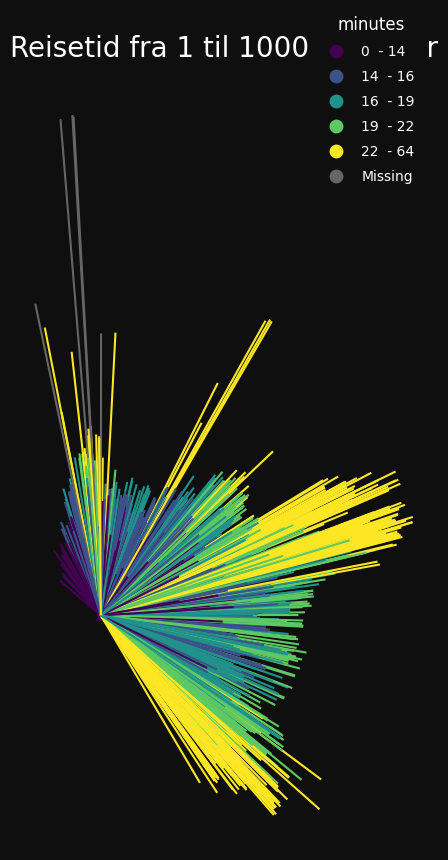

In [39]:
od = nwa.od_cost_matrix(
    punkter.sample(1),
    punkter,
    lines=True
)

m = sg.ThematicMap(od, column="minutes", size=10)
m.black = True
m.title = "Reisetid fra 1 til 1000 adresser"
m.scheme = "quantiles"
m.plot()

## Finn raskeste rute
Velger ett startpunkt for illustrasjons skyld.

In [35]:
routes = nwa.get_route(
    origins=punkter.iloc[[0]],
    destinations=punkter.sample(15),
)

routes

origin  destination    minutes  \
0        0          656  17.984539   
1        0           51  22.958288   
2        0          881  28.332227   
3        0          230  28.165429   
4        0          859  23.945514   
5        0          729  16.097410   
6        0          765  14.132669   
7        0           43  12.727342   
8        0           42  15.391739   
9        0          513  23.107895   
10       0          468  14.777220   
11       0          412   4.429345   
12       0          992   8.835359   
13       0           67  22.057456   
14       0          932  13.822138   

                                             geometry  
0   MULTILINESTRING Z ((262612.315 6649378.042 3.6...  
1   MULTILINESTRING Z ((265729.000 6649880.400 95....  
2   MULTILINESTRING Z ((262646.691 6647616.733 10....  
3   MULTILINESTRING Z ((266769.300 6642035.500 145...  
4   MULTILINESTRING Z ((265531.600 6646238.000 130...  
5   MULTILINESTRING Z ((265898.200 6652820.500 178...  
6   MULTILINESTRING Z ((257403.930 6653256.540 136...  
7   MULTILINESTRING Z ((257403.930 6653256.540 136...  
8   MULTILINESTRING Z ((260812.000 6651365.800 51....  
9   MULTILINESTRING Z ((262655.094 6647664.889 9.9...  
10  MULTILINESTRING Z ((261933.318 6649768.820 13....  
11  MULTILINESTRING Z ((256902.128 6654281.085 0.0...  
12  MULTILINESTRING Z ((256711.700 6653586.600 149...  
13  MULTILINESTRING Z ((265531.600 6646238.000 130...  
14  MULTILINESTRING Z ((260812.000 6651365.800 51....

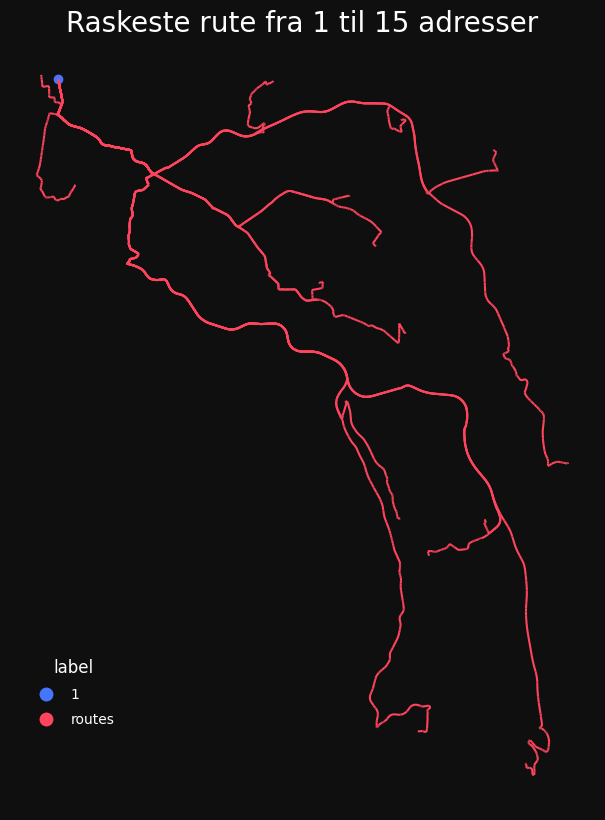

In [36]:
m = sg.ThematicMap(routes, punkter.iloc[[0]], size=10)
m.black = True
m.title = "Raskeste rute fra 1 til 15 adresser"
m.plot()

## Finn raskeste k ruter
k = antall

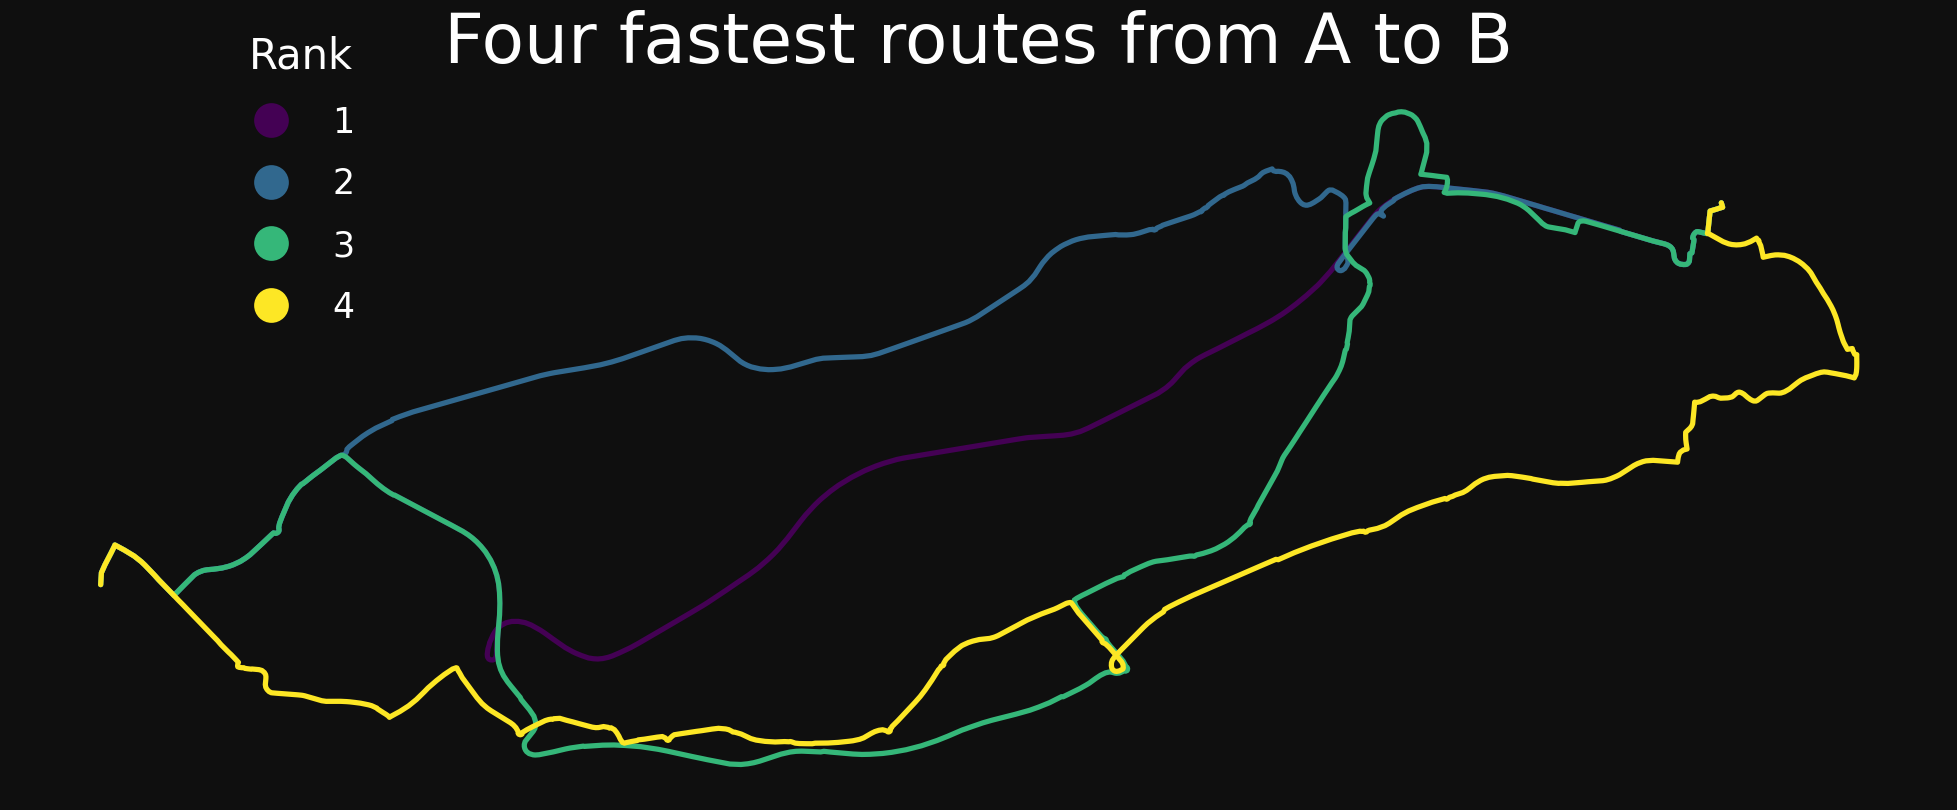

In [41]:
points = sg.read_parquet_url("https://media.githubusercontent.com/media/statisticsnorway/ssb-sgis/main/tests/testdata/points_oslo.parquet")

p1, p2 = points.iloc[[0]], points.iloc[[1]]

routes = nwa.get_k_routes(
    p1, p2, k=4, drop_middle_percent=50
)

m = sg.ThematicMap(sg.buff(routes, 15), column="k", black=True)
m.title = "Four fastest routes from A to B"
m.legend.title = "Rank"
m.plot()

Men kan stille strengere eller mindre strenge krav til hvor ulike rutene skal være. 

Med drop_middle_percent=50, fjernes midteste halvdel av ruta fra nettverket (midlertidig) før neste rute skal finnes.

La oss sjekke hvor mange ruter som blir funnet med drop_middle_percent=10:

origin  destination    minutes  k  \
0       0            1  13.209125  1   
1       0            1  14.253618  2   
2       0            1  14.407402  3   
3       0            1  15.066977  4   
4       0            1  16.386565  5   
5       0            1  16.682548  6   

                                            geometry  
0  MULTILINESTRING Z ((263586.600 6651120.600 47....  
1  MULTILINESTRING Z ((268554.230 6652166.290 120...  
2  MULTILINESTRING Z ((270318.800 6653023.100 121...  
3  MULTILINESTRING Z ((263586.600 6651120.600 47....  
4  MULTILINESTRING Z ((270246.400 6652365.200 123...  
5  MULTILINESTRING Z ((270246.400 6652365.200 123...

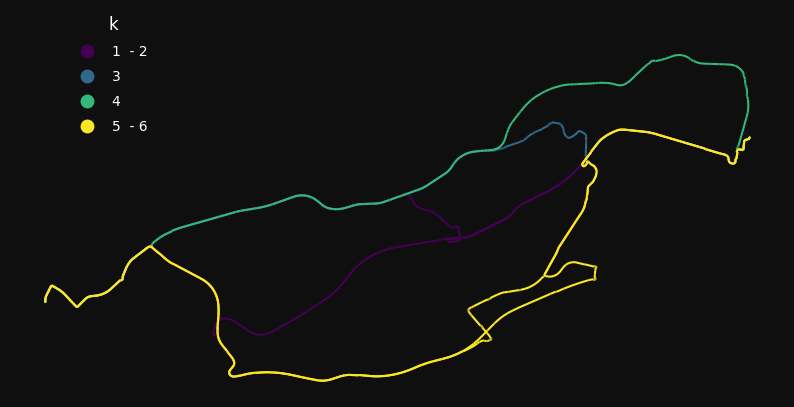

In [44]:
k_routes = nwa.get_k_routes(p1, p2, k=100, drop_middle_percent=10)

sg.qtm(k_routes, "k")

k_routes

Den fant seks ruter. Med drop_middle_percent=100, finner man bare én rute:

origin  destination    minutes  k  \
0       0            1  13.209125  1   

                                            geometry  
0  MULTILINESTRING Z ((263586.600 6651120.600 47....

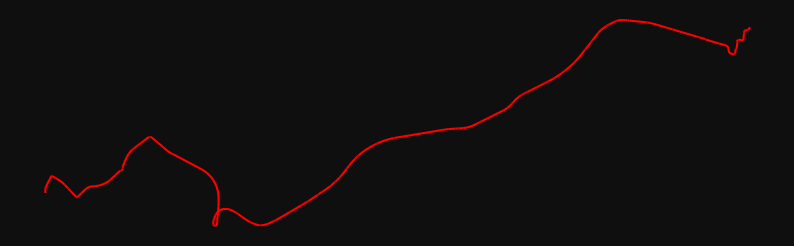

In [43]:
k_routes = nwa.get_k_routes(p1, p2, k=4, drop_middle_percent=100)

sg.qtm(k_routes, "k", color="red")

k_routes